In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
mask_on = cv2.imread('New Masks Dataset/Train/Mask/0003.jpg') 
mask_on = cv2.cvtColor(mask_on,cv2.COLOR_BGR2RGB)

In [3]:
type(mask_on)

numpy.ndarray

In [4]:
mask_on.shape

(2002, 3000, 3)

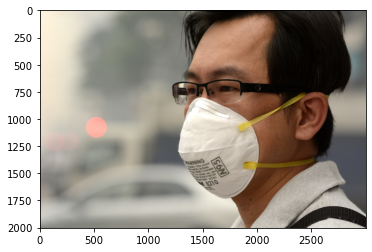

In [5]:
plt.imshow(mask_on)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
image_gen = ImageDataGenerator(rotation_range=35, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.3, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.3, # Zoom in by 20% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

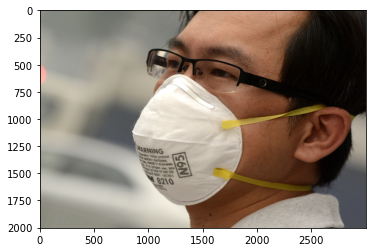

In [8]:
plt.imshow(image_gen.random_transform(mask_on))

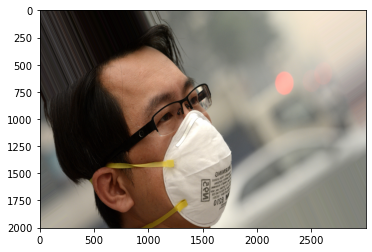

In [9]:
plt.imshow(image_gen.random_transform(mask_on))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [10]:
image_gen.flow_from_directory('New Masks Dataset/Train') 
image_gen.flow_from_directory('New Masks Dataset/Test')

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
image_gen.flow_from_directory('New Masks Dataset/Validation')

Found 306 images belonging to 2 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

# Creating the Model

In [12]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=mask , 1=non mask
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### Training the Model

In [15]:
batch_size = 32

train_image_gen = image_gen.flow_from_directory('New Masks Dataset/Train',
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 600 images belonging to 2 classes.


In [16]:
test_image_gen = image_gen.flow_from_directory('New Masks Dataset/Test',
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 100 images belonging to 2 classes.


In [17]:
train_image_gen.class_indices

{'Mask': 0, 'Non Mask': 1}

In [18]:
valid_image_gen = image_gen.flow_from_directory('New Masks Dataset/Validation',
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 306 images belonging to 2 classes.


In [19]:
results = model.fit_generator(train_image_gen,epochs=50,steps_per_epoch=2,
                              validation_data=valid_image_gen)

C:\Users\janardhan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
2/2 [==============================] - 18s 13s/step - loss: 0.7482 - accuracy: 0.3438 - val_loss: 0.7254 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 9s 8s/step - loss: 0.8168 - accuracy: 0.4583 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 16s 15s/step - loss: 0.6847 - accuracy: 0.5000 - val_loss: 0.6723 - val_accuracy: 0.7582
Epoch 4/50
2/2 [==============================] - 11s 10s/step - loss: 0.6764 - accuracy: 0.6250 - val_loss: 0.6530 - val_accuracy: 0.7451
Epoch 5/50
2/2 [==============================] - 15s 13s/step - loss: 0.6194 - accuracy: 0.7500 - val_loss: 0.6367 - val_accuracy: 0.5131
Epoch 6/50
2/2 [==============================] - 16s 14s/step - loss: 0.6714 - accuracy: 0.5833 - val_loss: 0.5557 - val_accuracy: 0.8268
Epoch 7/50
2/2 [==============================] - 16s 15s/step - loss: 0.5115 - accuracy: 0.8958 - val_loss: 0.4906 - val_accuracy: 0.8627
Epoch 8/50
2/2 [=============

In [20]:
model.save('mask_detect.h5')

# Evaluating the Model

In [22]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

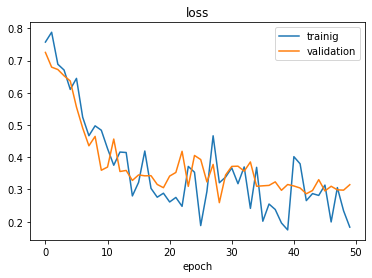

In [24]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['trainig','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

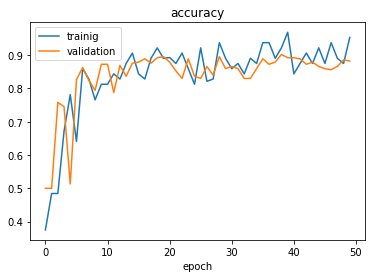

In [26]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['trainig','validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [27]:
test_loss , test_acc = model.evaluate(test_image_gen)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 2s 395ms/step - loss: 0.2865 - accuracy: 0.8400
test acc :0.8399999737739563 test loss:0.2864510416984558


# Predicting on new images

In [28]:
train_image_gen.class_indices

{'Mask': 0, 'Non Mask': 1}

In [29]:
from keras.models import load_model

In [30]:
model = load_model('mask_detect.h5')

In [33]:
import numpy as np
from keras.preprocessing import image

masked_file = 'New Masks Dataset/Test/Mask/2083.jpg'

masked_img = image.load_img(masked_file, target_size=(150, 150))

masked_img = image.img_to_array(masked_img)

masked_img = np.expand_dims(masked_img, axis=0)
masked_img = masked_img/255

In [34]:
prediction_prob = model.predict(masked_img)
# Output prediction
print(f'Probability that person in image is wearing a mask is: {prediction_prob} ')

Probability that person in image is wearing a mask is: [[0.07263988]] 


In [35]:
model.predict_classes(masked_img)

C:\Users\janardhan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0]])

### So it has predicted that person is masked correctly!

In [37]:
actual_img=cv2.imread(masked_file)
actual_img=cv2.cvtColor(actual_img,cv2.COLOR_BGR2RGB)

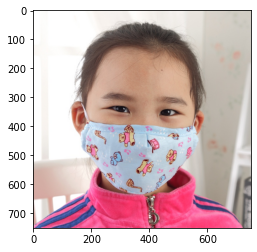

In [38]:
plt.imshow(actual_img)